Seismic Data Reconstruction and Denoising based on Online Dictionary Learning 
=======================
---------------------

This function introduces a new optimization strategy in seismic data reconstruction and noise attenuation by using state-of-the-art **online dictionary learning (ODL)** sparse coding, which has fast convergence (Mairal et al. 2009). Field data examples indicate that the proposed method can reduce the computation cost significantly. Assisted in **Mini-Batch** and **Orthogonal Matching Persuit(OMP)** technology, ODL shows better performance and achieve higher S/N ratio than classical DL algorithms. The ODL trained dictionary can keep great preservation of useful signal with rarely leakage.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Dec  7 19:06:19 2017

@author: maihao
maihao14@126.com
maihaoforgetcode@gmail.com
"""
import numpy as np
import scipy as sp
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from time import time
import matplotlib.pyplot as plt
import scipy.io as sio
import random

*Import required packages*

In [3]:
path = '/Users/maihao/Documents/GitHub/Lina-Seismic-Playground/DATA/'
file = 'Synmodule.mat'
file1 = 'SynNoise.mat'
DATA =  sio.loadmat(path+file)

ascent = DATA['s'].copy()
height, width = ascent.shape

DATA_Noi =  sio.loadmat(path+file1)
disorted = DATA_Noi['SynNoise'].copy()

*Import Synthetic Seismic modlule *

In [13]:
def SNR(I,In):
#计算信号噪声比函数
#I: original signal
#In: noisy signal(ie. original signal + noise signal)
#snr=10*log(sigma2(I2)/sigma2(I2-I1))
    Ps = np.sum(np.sum(np.square(I))) #signal power
    Pn = np.sum(np.sum(np.square(In-I))) #noise power
    snr = 10*np.log10(Ps/Pn)
    return snr


#calculate SNR
snr = SNR(ascent,disorted)
###############################################################################
# Display the distorted image

def show_with_diff(image, reference, title,snr):
    """Helper function to display denoising"""
    plt.figure(figsize=(14, 13))
    plt.subplot(1, 3, 1)
    plt.title('Orignal Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation='nearest')
    plt.xlabel('Trace Number')
    plt.ylabel('Time sampling Number')
    plt.subplot(1, 3, 2)
    plt.title('Denoised Image')
    plt.imshow(reference, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation='nearest')
    plt.xlabel('Trace Number')
    plt.ylabel('Time sampling Number')
    plt.subplot(1, 3, 3)
    difference =  reference - image 

    plt.title('Difference (SNR: %.2fdB)' % snr)
    plt.imshow(difference, vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xlabel('Trace Number')
    plt.ylabel('Time sampling Number')
    plt.suptitle(title, size=14)

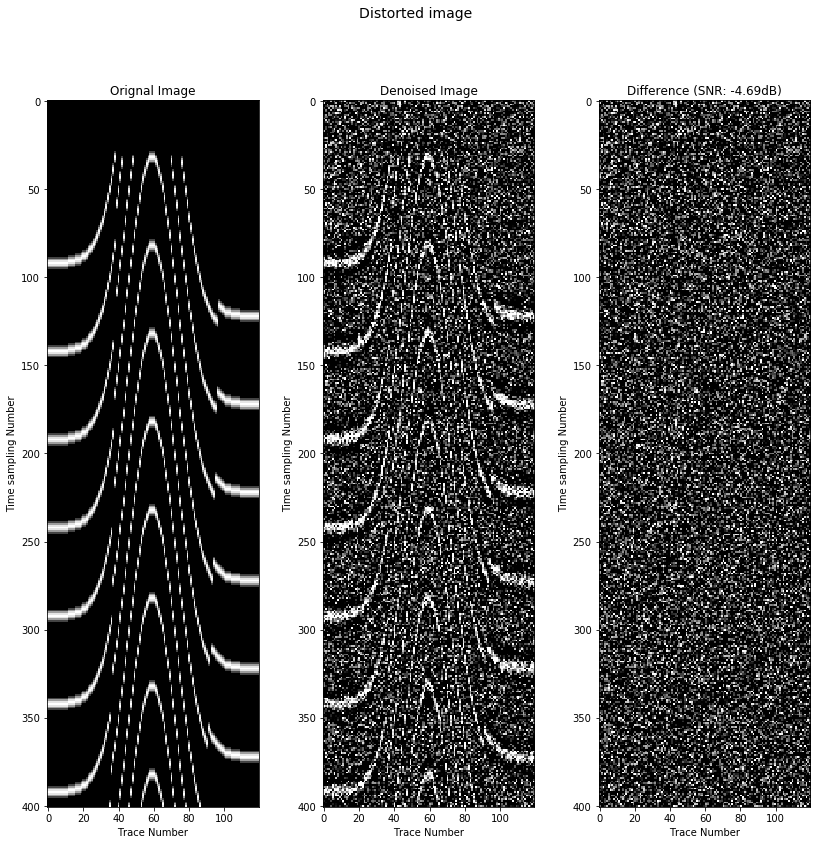

In [14]:
show_with_diff(ascent, disorted, 'Distorted image',SNR(ascent,disorted))
plt.show()

*Plot Synthetic Module and add noised module*

In [26]:
# Extract all reference patches from the data
print('Extracting reference patches...')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(ascent[:, :], patch_size)
#data = extract_patches_2d(ascent, patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print('done in %.2fs.' % (time() - t0))


Extracting reference patches...
done in 0.03s.


Learning the dictionary...
done in 18.98s.


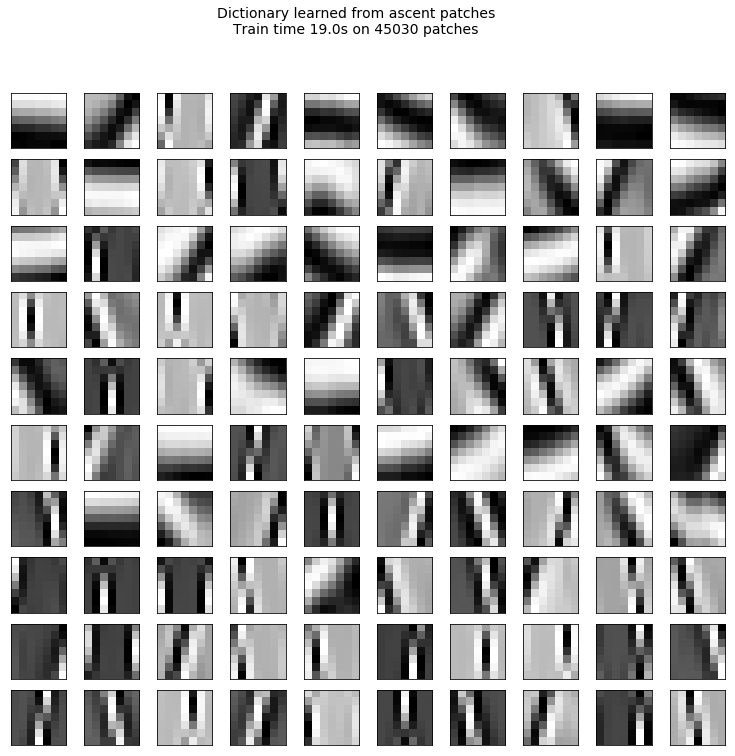

In [21]:
###############################################################################
# Learn the dictionary from reference patches
%matplotlib inline
print('Learning the dictionary...')
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1, n_iter=5000)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

plt.figure(figsize=(13, 12))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from ascent patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=14)
plt.subplots_adjust(wspace = 0.1, hspace = 0.2 )


*Here we have got trained dictionary*

Extracting noisy patches... 
done in 0.01s.
Orthogonal Matching Pursuit
1 atom...
Orthogonal Matching Pursuit
2 atoms...


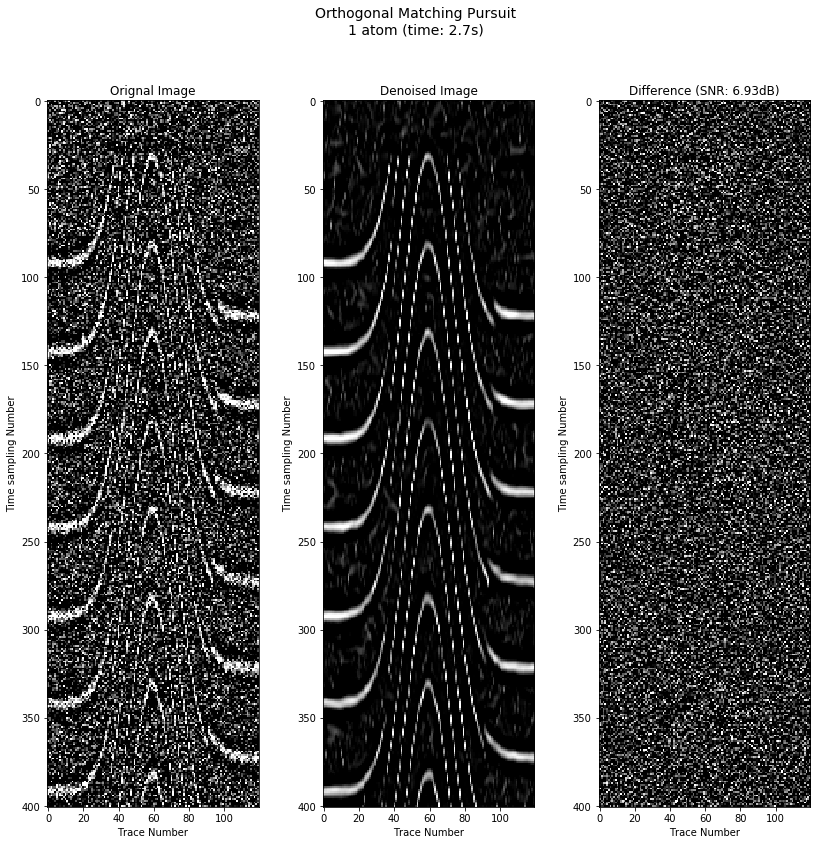

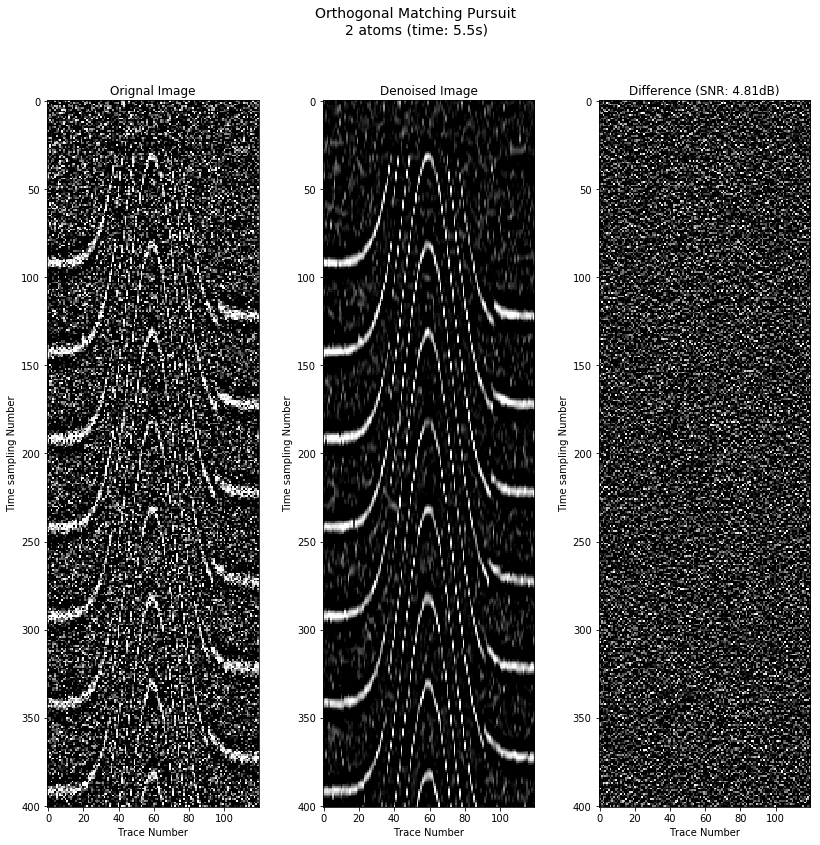

In [22]:
###############################################################################
# Extract noisy patches and reconstruct them using the dictionary

print('Extracting noisy patches... ')
t0 = time()
data = extract_patches_2d(disorted[:, :], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))

transform_algorithms = [
    ('Orthogonal Matching Pursuit\n1 atom', 'omp',
     {'transform_n_nonzero_coefs': 1}),
    ('Orthogonal Matching Pursuit\n2 atoms', 'omp',
     {'transform_n_nonzero_coefs': 2})]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    
    print(title + '...')
    reconstructions[title] = disorted.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, :] = reconstruct_from_patches_2d(
        patches, (401,120))
    dt = time() - t0
    #print('done in %.2fs.' % dt)
    
    
    ans = SNR(ascent,reconstructions[title])
    #print (np.max(reconstructions[title]),np.min(reconstructions[title]))
    #'''
    show_with_diff(disorted,reconstructions[title], 
                   title + ' (time: %.1fs)' % dt,ans)
    #'''
plt.show()